In [1]:
import brian2 as br
import pandas as pd
import sympy
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import dh_parameters as dp
import dh_model as dh
import numpy as np

from scipy import optimize as op
%matplotlib inline

from importlib import reload
reload(dp);
reload(dh);

In [2]:
nts = ['pr_noci','e_nts','i_gal']
ats = ['pep2','AB_ltmr']
Ns = dp.get_Ns()
intrinsics_df = dp.intrinsics_table_w_units()
ng_output_dfs = dp.interneuronal_connectivity_tables()
ag_output_dfs = dp.afferent_connectivity_tables()

In [3]:
ndf = {}
adf ={}
for param,df in ng_output_dfs.items():
    ndf[param] = ng_output_dfs[param].loc[['pr_noci','e_nts','i_gal'],['pr_noci','e_nts','i_gal']]

for param,df in ag_output_dfs.items():
    adf[param] = ag_output_dfs[param].loc[['pep2'],['pr_noci','e_nts','i_gal']]    
    
for param,df in ndf.items():
    ndf[param].columns = ['pr_noci', 'e_nts', 'i_WDR']
    ndf[param].index = ['pr_noci', 'e_nts', 'i_WDR']
    
for param,df in adf.items():
    adf[param].columns = ['pr_noci', 'e_nts', 'i_WDR']
    
ndf['p'].loc['i_WDR'] = [1,1,1]
ndf['w_mu'].loc['i_WDR'] = [1e-9,1e-9,1e-9]
ndf['w_sigma'].loc['i_WDR'] = [1e-10,1e-10,1e-10]
ndf['conductance_name'].loc['i_WDR']=['i','i','i']

ndf['p'].loc['e_nts'] = [1,1,1]
ndf['w_mu'].loc['e_nts'] = [0.5e-9,0.5e-9,0.5e-9]
ndf['w_sigma'].loc['e_nts'] = [1e-10,1e-10,1e-10]
ndf['conductance_name'].loc['e_nts']=['e','e','e']

adf['p'].loc['pep2'] = [1,0.,1]
adf['w_mu'].loc['pep2'] = [2e-9,1e-9,1e-9]
adf['w_sigma'].loc['pep2'] = [1e-10,1e-10,1e-10]
adf['conductance_name'].loc['pep2']=['e','e','e']

adf['p'].loc['AB_ltmr'] = [0,1,1]
adf['w_mu'].loc['AB_ltmr'] = [1e-9,1e-9,1e-9]
adf['w_sigma'].loc['AB_ltmr'] = [1e-10,1e-10,1e-10]
adf['conductance_name'].loc['AB_ltmr']=['e','e','e']


nts = ['pr_noci', 'e_nts', 'i_WDR']
Ns['pr_noci'] = 20
Ns['e_nts'] = 20
Ns['i_WDR'] = 10
Ns['pep2'] = 100
Ns['AB_ltmr'] = 100

intrinsics_df.loc['i_WDR'] = intrinsics_df.loc['i_gal']


In [4]:
################################################################################
# Model parameters
################################################################################
### General parameters

duration = 25*br.ms  # Total simulation time
sim_dt = 0.1*br.ms        # Integrator/sampling step
br.defaultclock.dt = sim_dt

In [5]:
# initialize network
ngs = {}
spike_mons = {}
poprates = {}
synapses = []
states = {}
for nt in nts:
    ng = dh.adex_group(name = nt, N = Ns[nt])
    ng.set_intrinsics_from_dfs(intrinsics_df)
    ng.initialize_I_ex_array(duration,sim_dt)
    ngs[nt] = ng
    spike_mons[nt]= br.SpikeMonitor(ngs[nt], record=True)  
    poprates[nt] = br.PopulationRateMonitor(ngs[nt])
    states[nt]= br.StateMonitor(ngs[nt],variables = 'v', record=False) 
    
ags = {}
for at in ats:
    ags[at] = dh.afferent_group(name = at, N = Ns[at])   
    
s = dh.connect_all_ngs_from_dfs(ngs,ndf)
s.update(dh.connect_all_ags_from_dfs(ngs,ags,adf))

# net = Network(ngs,ags,s,spks,states,poprates)
net = br.Network(ngs,ags,s,spike_mons,states)
net.store()

WARNING    /Users/nakaa1/anaconda3/envs/brian/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
 [py.warnings]


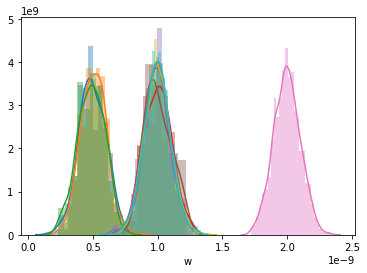

In [6]:
f,ax = plt.subplots()
for ws in s.values():
    sns.distplot(ws.w,ax = ax)

In [7]:
#output = tensor: rates x psth x num_trials
num_trials = 600
block_length = 50
conditions = 4
num_repeats = 3
trial_durations = [duration] * num_trials
inputs = dh.initialize_inputs(ags,ngs,num_trials,trial_durations = trial_durations)
psth_kernel,_ = dh.gaussian_psth(duration, sim_dt, mu = 12.5 * br.ms, sigma = 3 * br.ms)

rates_of_active_pep2 = np.ones((num_trials)) * 10.
rates_of_active_AB_ltmr = np.ones((num_trials)) * 10.


# frac_active_pep2 = np.concatenate([np.logspace(-3,0,block_length),
#                                    np.zeros(block_length)] * 2 * num_repeats)
# frac_active_pep2 = np.concatenate([np.linspace(0.001,1,block_length),
#                                    np.zeros(block_length)] * 2 * num_repeats)
# heat = ([True]*block_length +[False] * block_length) * 2 * num_repeats

# frac_active_AB_ltmr = np.concatenate([np.zeros(block_length),
#                                       np.logspace(-3,0,block_length)] * 2 * num_repeats )
# frac_active_AB_ltmr = np.concatenate([np.zeros(block_length),
#                                       np.linspace(0.001,1,block_length)] * 2 * num_repeats )
# mech = ([False]*block_length +[True] * block_length) * 2 * num_repeats

# frac_active_pep2 = np.random.rand(num_trials)
# frac_active_AB_ltmr = np.random.rand(num_trials)

frac_active_pep2 = np.concatenate([np.logspace(-3,0,block_length),
                                   np.zeros(block_length),
                                   np.random.rand(block_length*2)*0.5] * num_repeats )
heat = ([True]*block_length +[False] * block_length +[False] * block_length*2)  * num_repeats
frac_active_AB_ltmr = frac_active = np.concatenate([np.zeros(block_length),
                                                    np.logspace(-3,0,block_length),
                                                    np.random.rand(block_length*2)*0.5] * num_repeats)
mech = ([False] * block_length + [True] * block_length + [False] * block_length*2) * num_repeats

at = 'pep2'
for trial,frac in enumerate(frac_active_pep2):
    _, active_binary = dh.make_active_inds_binary(frac, ags[at].N)
    rate_vec = np.ones((ags[at].N))* rates_of_active_pep2[trial] * active_binary
    spike_times,indices = dh.generate_population_spikes(psth_kernel,rate_vec,sim_dt)
    inputs[trial][at]['spike_times'] = spike_times
    inputs[trial][at]['indices'] = indices


at = 'AB_ltmr'
for trial,frac in enumerate(frac_active_AB_ltmr):
    _, active_binary = dh.make_active_inds_binary(frac, ags[at].N)
    rate_vec = np.ones((ags[at].N))* rates_of_active_AB_ltmr[trial] * active_binary
    spike_times,indices = dh.generate_population_spikes(psth_kernel,rate_vec,sim_dt)
    inputs[trial][at]['spike_times'] = spike_times
    inputs[trial][at]['indices'] = indices
    
df = pd.DataFrame({'frac_active_pep2':frac_active_pep2,
                   'frac_active_AB_ltmr':frac_active_AB_ltmr})
df['heat'] = heat
df['mech'] = mech


# nt = 'i_WDR'
# silenced_i_WDR = np.concatenate([np.zeros(block_length*2),np.ones(block_length*2)*-50000]* num_repeats )
# for trial,current in enumerate(silenced_i_WDR):
#     inputs[trial][nt]['I_ex'] += current
    
# df['silenced_i_WDR'] = silenced_i_WDR
# df['silenced'] = df['silenced_i_WDR']<0

In [8]:
target_outputs = dh.initialize_target_outputs(inputs)

# rate_vec = np.linspace(0,4,num_trials)
# target_outputs = dh.add_target_mean_rate(target_outputs, rate_vec, 'pr_WDR')

# rate_vec = [0.,0.,0.,1.,2., 3., 4., 4.]
# target_outputs = dh.add_target_mean_rate(target_outputs, rate_vec, 'pr_noci')

In [9]:
# update_funcs = {}
# ng_vpl= [('pr_WDR','g_l_mu')]
# update_funcs.update(dh.gen_intrinsics_update_funcs(ngs,ng_vpl))
# s_var_names = ['pep2_to_pr_noci','pep2_to_i_WDR','pep2_to_pr_WDR',
#                'AB_ltmr_to_pr_noci','AB_ltmr_to_i_WDR','AB_ltmr_to_pr_WDR',
#                'i_WDR_to_pr_noci','i_WDR_to_pr_WDR',]
# update_funcs.update(dh.gen_s_w_update_funcs(s,))
# update_funcs

In [10]:
sim_objects ={}
sim_objects['network'] = net
sim_objects['neuron_groups'] = ngs
sim_objects['afferent_groups'] = ags
sim_objects['synapses'] = s
sim_objects['spike_mons'] = spike_mons
sim_objects['sim_dt'] = sim_dt
sim_objects['inputs'] = inputs
sim_objects['target_outputs'] = target_outputs

In [11]:
I_ex_arrays,ag_inputs_full_trial = dh.concat_inputs(inputs,sim_objects)

In [12]:
bins = np.arange(0,sum(trial_durations),1*br.ms)


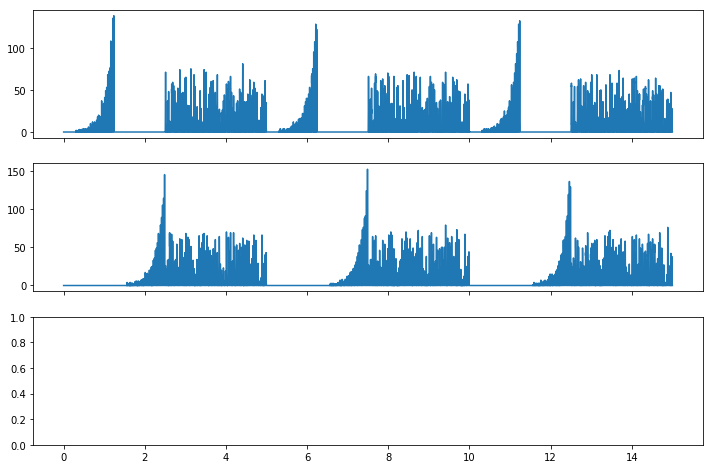

In [13]:
f,ax = plt.subplots(3,1,figsize = (12,8),sharex = True)
ax.flatten()
psth,bins = np.histogram(ag_inputs_full_trial['pep2']['spike_times'],bins)
ax[0].plot(bins[:-1],psth)
psth,bins = np.histogram(ag_inputs_full_trial['AB_ltmr']['spike_times'],bins)
ax[1].plot(bins[:-1],psth)
# ax[0].set_xlim((0,1000))

In [14]:
def stack_I_ex_arrays(I_ex_arrays):
    return np.concatenate(list(I_ex_arrays.values()),axis = 1)

# def spike_times_to_psth()

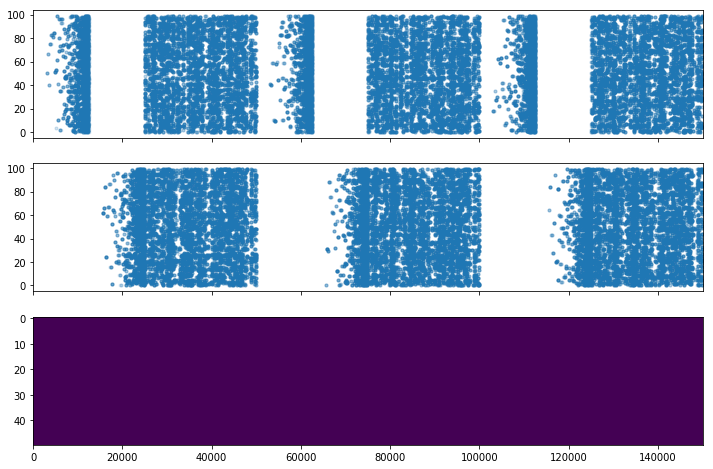

In [16]:
f,ax = plt.subplots(3,1,figsize = (12,8),sharex = True)
ax.flatten()
ax[0].plot(ag_inputs_full_trial['pep2']['spike_times']/sim_dt,ag_inputs_full_trial['pep2']['indices'],'.',alpha = 0.1)
ax[1].plot(ag_inputs_full_trial['AB_ltmr']['spike_times']/sim_dt,ag_inputs_full_trial['AB_ltmr']['indices'],'.',alpha = 0.1)
ax[2].imshow(stack_I_ex_arrays(I_ex_arrays).T,aspect = 'auto')

In [17]:
net.restore()
cost, observed_spikes = dh.run_sim(sim_objects, inputs, target_outputs, dh.mean_spike_count_cost_func)

In [18]:
for j,nt in enumerate(nts):
    this_rates = [observed_spikes[i][nt]['mean_count'] for i in range(len(observed_spikes))]
    df[nt+'_mean_rate'] = this_rates

In [22]:
x, xm, y, ym = sim_results_to_psth_tensors(sim_objects)

In [20]:
def sim_results_to_psth_tensors(sim_objects,psth_duration = None, binsize = 1*br.ms):
    num_trials = len(sim_objects['inputs'])
    if not psth_duration:
        psth_duration = sim_objects['inputs'][0]['trial_duration']
    bins = np.arange(0*br.ms,duration+binsize,binsize)
    len_time = len(bins)-1
    
    N_ngs = 0
    for ng in sim_objects['neuron_groups']:
        N_ngs += sim_objects['neuron_groups'][ng].N

    N_ags = 0
    for ag in sim_objects['afferent_groups']:
        N_ags += sim_objects['afferent_groups'][ag].N
    
    
    y = np.zeros((num_trials,len_time,N_ngs))
    ym = np.zeros((num_trials,len_time,len(sim_objects['neuron_groups'])))

    x = np.zeros((num_trials, len_time, N_ags))
    xm = np.zeros((num_trials, len_time, len(sim_objects['afferent_groups'])))
    
    for i in range(num_trials):
        this_start = (i-1) * sim_objects['inputs'][i]['trial_duration']
        this_end = i * sim_objects['inputs'][i]['trial_duration']
        y_i = 0
        for j,nt in enumerate(sim_objects['neuron_groups']):
            all_spikes = sim_objects['spike_mons'][nt].t
            spike_trains = sim_objects['spike_mons'][nt].spike_trains()
            this_spikes = all_spikes[(all_spikes>=this_start) & (all_spikes<this_end)]-this_start
            psth,binout = np.histogram(this_spikes,bins)
            ym[i,:,j] = psth
            for this_spike_train in spike_trains.values():
                psth,binout = np.histogram((this_spike_train -this_start),bins)
                y[i,:,y_i] = psth
                y_i+=1
                
        x_i = 0    
        for j,at in enumerate(sim_objects['afferent_groups']):
            all_spikes = sim_objects['inputs'][i][at]['spike_times']
            psth,binout = np.histogram(all_spikes,bins)
            xm[i,:,j] = psth
            for this_ind in range(sim_objects['afferent_groups'][at].N):
                this_spikes = all_spikes[sim_objects['inputs'][i][at]['indices'] == this_ind]
                psth,binout = np.histogram(this_spikes,bins)
                x[i,:,x_i] = psth
                x_i+=1
            
            
    return x, xm, y, ym

            
# for i in range(num_trials):
#     this_start = (i-1) * duration
#     this_end = i * duration
#     for j,nt in enumerate(nts):
#         all_spikes = spike_mons[nt].t
#         this_spikes = all_spikes[(all_spikes>=this_start) & (all_spikes<this_end)]-this_start
#         psth,binout = np.histogram(this_spikes,bins)
#         ym[i,:,j] = psth
        
#     for j,at in enumerate(ats):
#         all_spikes = inputs[i][at]['spike_times']
#         psth,binout = np.histogram(all_spikes,bins)
#         xm[i,:,j] = psth


In [23]:
np.save('/Users/nakaa1/data/xm',xm)
np.save('/Users/nakaa1/data/ym',ym)
np.save('/Users/nakaa1/data/x',x)
np.save('/Users/nakaa1/data/y',y)

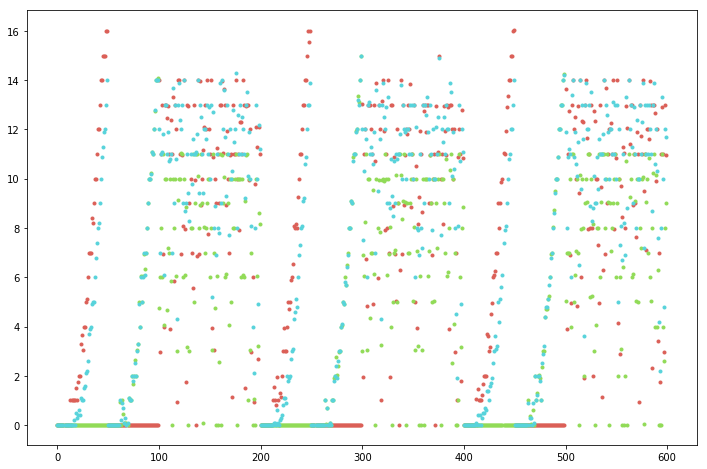

In [24]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(1,1,figsize = (12,8), sharex = True)
y_bias = 0
for j,nt in enumerate(nts):
    this_rates = [observed_spikes[i][nt]['mean_count'] for i in range(len(observed_spikes))]
    ax.plot(this_rates,'.',color=cmap[j])

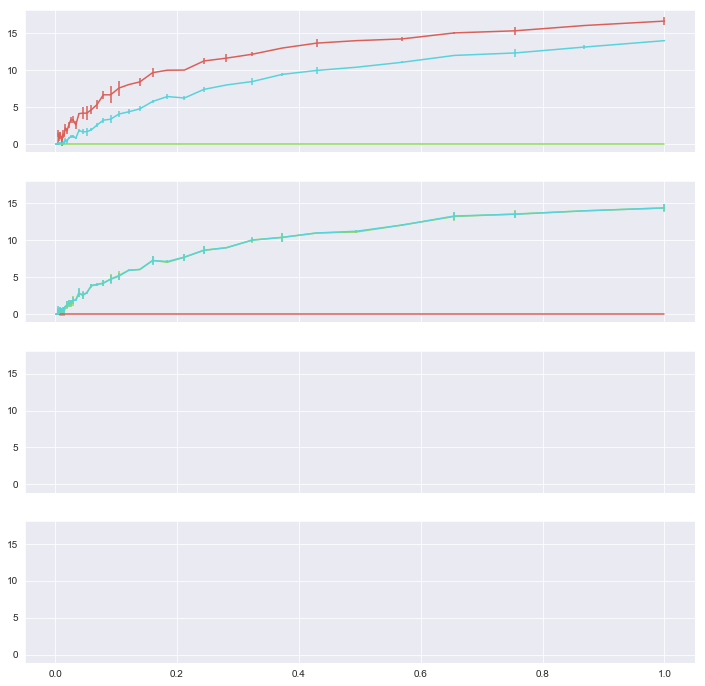

In [56]:
sns.set_style('darkgrid')
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(4,1,figsize = (12,12), sharex = True,sharey = True)
ax = ax.flatten()

heat_ctrl = df['heat'] & ~ df['silenced']
mech_ctrl = df['mech'] & ~ df['silenced']
heat_sil = df['heat'] & df['silenced']
mech_sil = df['mech'] & df['silenced']

# heat_ctrl = df['heat'] 
# mech_ctrl = df['mech'] 

inds = [heat_ctrl,mech_ctrl]
ivs = ['frac_active_pep2','frac_active_AB_ltmr']

inds = [heat_ctrl,mech_ctrl,heat_sil,mech_sil]
ivs = ['frac_active_pep2','frac_active_AB_ltmr','frac_active_pep2','frac_active_AB_ltmr']
for i, (ind,iv) in enumerate(zip(inds,ivs)):
    this_df = df[ind]
    agg_df = this_df.groupby(iv).agg(['mean','std']).reset_index()
    ax[i].errorbar(agg_df[iv],agg_df['pr_noci_mean_rate']['mean'],agg_df['pr_noci_mean_rate']['std'],color = cmap[0])
    ax[i].errorbar(agg_df[iv],agg_df['e_nts_mean_rate']['mean'],agg_df['e_nts_mean_rate']['std'],color = cmap[1])
    ax[i].errorbar(agg_df[iv],agg_df['i_WDR_mean_rate']['mean'],agg_df['i_WDR_mean_rate']['std'],color = cmap[2])

In [ ]:
heat_ctrl_input = inputs[25]

In [ ]:
net.restore()
cost, observed_spikes = dh.run_sim(sim_objects, heat_ctrl_input, target_outputs, dh.mean_spike_count_cost_func)

(0, 1000)

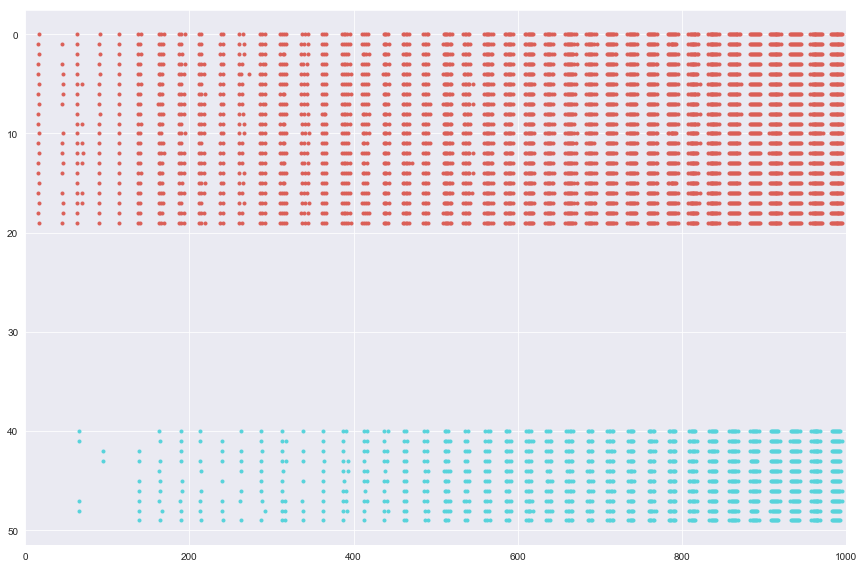

In [29]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(1,1,figsize = (12,8), sharex = True)
y_bias = 0
for j,(ct,spike_mon) in enumerate(spike_mons.items()):
    ax.plot(spike_mon.t/br.ms, spike_mon.i + y_bias,'.', color = cmap[j],alpha = 1);
    y_bias += ngs[ct].N
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
ax.set_xlim((0,net.t/br.ms))
ax.set_xlim((0,1000))

In [ ]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(1,1,figsize = (12,8), sharex = True)
y_bias = 0
for j,(ct,spike_mon) in enumerate(spike_mons.items()):
    ax.plot(spike_mon.t/br.ms, spike_mon.i + y_bias,'.', color = cmap[j],alpha = 1);
    y_bias += ngs[ct].N
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
ax.set_xlim((0,net.t/br.ms))
ax.set_xlim((0,300))

In [ ]:
state_mon.v.shape

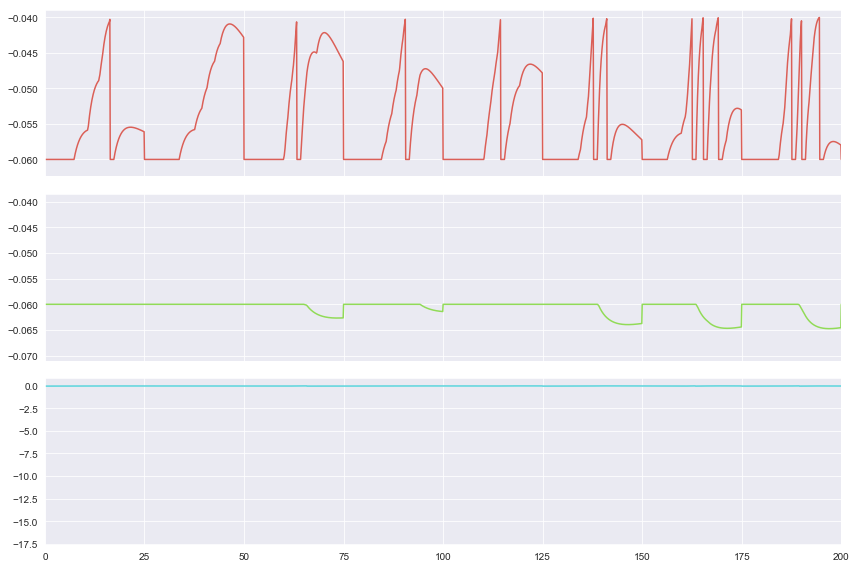

In [24]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(3,1,figsize = (12,8), sharex = True)
ax = ax.flatten()
y_bias = 0
for j,(ct,state_mon) in enumerate(states.items()):
    ax[j].plot(state_mon.t/br.ms, state_mon.v[0,:], color = cmap[j]);
#     y_bias += ngs[ct].N
    ax[j].set_xlim((0,200))
    y_bias+=1
plt.tight_layout()

# ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
# ax.set_xlim((0,net.t/br.ms))

In [ ]:
bins = np.arange(0,net.t/br.ms,10)
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(3,1,figsize = (12,8), sharex = True)
ax = ax.flatten()
y_bias = 0
for j,(ct,spike_mon) in enumerate(spike_mons.items()):
    sns.distplot(spike_mon.t/br.ms, ax = ax[j], bins = bins, color = cmap[j])
plt.tight_layout()

# ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
# ax.set_xlim((0,net.t/br.ms))

In [ ]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
y_bias = 0
for j,(ct,spike_mon) in enumerate(spike_mons.items()):
    ax.plot(spike_mon.t/ms, spike_mon.i + y_bias,'.', color = cmap[j],alpha = 1);
    y_bias += ngs[ct].N
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
ax.set_xlim((0,net.t/ms))

In [ ]:
update_funcs = {}
# ng_vpl= [('pr_WDR','E_l'),('e_WDR','E_l')]
# update_funcs.update(gen_intrinsics_update_funcs(ngs,ng_vpl))
update_funcs.update(gen_s_w_update_funcs(s))

In [ ]:
global tracker
tracker ={}
tracker['beta'] = []
tracker['observed_spikes'] =[]
tracker['cost']=[]
opts = {}
opts['tracker'] = tracker
opts['track'] = True
opts['verbose'] = True

bounds = [(0,5)] * 6 + [(0,1)] * 3

res = op.differential_evolution(func = dh.fit_network,bounds = bounds,
    args = [update_funcs, sim_objects, inputs, target_outputs, dh.mean_spike_count_cost_func, opts],polish = False,
    maxiter = 30)

In [ ]:
def calc_pop_rates_per_trial(spks,num_trials,duration):
    ng_counts = {}
    ng_counts_avg ={}
    for nt,spikemon in spks.items():
        trial_start = 0 * ms
        spike_trains = spikemon.spike_trains()
        ng_counts[nt] = np.zeros((len(spike_trains.keys()),num_trials))
        ng_counts_avg[nt] = np.zeros((num_trials))
        for trial in range(num_trials):
            trial_end = trial_start + duration
            for n,times in spike_trains.items():
                this_count = sum((times>=trial_start) & (times<trial_end))
                ng_counts[nt][n,trial]= this_count
            ng_counts_avg[nt][trial] = ng_counts[nt][:,trial].mean()
            trial_start += duration
    return ng_counts,ng_counts_avg

def cost_func(target_ng_rates, measured_ng_rates, nts = ['pr_noci','pr_WDR']):
    cost = 0.
    for nt in nts:
        cost += sum((target_ng_rates[nt] - measured_ng_rates[nt])**2) **0.5
    return cost

In [ ]:
st = spike_mons['i_WDR'].spike_trains()[0]
trial_start = 20*ms
trial_end = 50 * ms
st[(st>=trial_start) & (st<trial_end)]

In [ ]:
trialwise_spikes = get_trialwise_spikes(inputs, sim_objects)
trialwise_spikes[0]['i_WDR']

In [ ]:
target_outputs

In [ ]:
inputs[0]['pr_noci']

In [ ]:
def adjust_params_and_rerun(net, ngs, ags, s, beta):
    net.restore()
    
    for name, w_mu in beta.items():
        for syn in s:
            if syn.name == name:
                syn.w = (w_mu + 0.000001 * randn(syn.w.shape[0]))* nS
                syn.w['w < 0 * nS'] = 0 * nS
                
    #resetting
    for trial in range(num_trials):
        for nt,ng in ngs.items():
            ng.reset_variables()
        for at,ag in ags.items():
            this_rate = ag_rates[at][trial]
            psth, time_bins = uniform_psth()
            rates = np.ones((ag.N)) * this_rate
            spikes,ind = generate_population_spikes(psth,rates)
            ag.set_spikes(indices = ind, times = spikes + net.t)
        net.run(duration)


    ng_counts,ng_counts_avg = calc_pop_rates_per_trial(spks,num_trials,duration)
    measured_ng_rates = {}
    for nt,counts_avg in ng_counts_avg.items():
        measured_ng_rates[nt] = counts_avg / duration*second    
    return measured_ng_rates

def run_network_change_syn(x, net, ngs, ags, s, free_s_params, target_ng_rates):
    beta = {}
    for free_s_param,this_x in zip(free_s_params,x):
        beta[free_s_param] = this_x
    measured_ng_rates = adjust_params_and_rerun(net, ngs, ags, s, beta)
    cost = cost_func(target_ng_rates, measured_ng_rates, nts = ['pr_noci','pr_WDR'])
    
#     beta_.append(x)
#     rates_.append(rates)
#     cost_.append(cost)
    print(x, cost)

    return cost

In [ ]:
bounds = [(0.5,8),(0.5,8),(0.5,8),(0.5,8),(0.5,8),(0.5,8)]
bounds = [(0.5,8)] * len(free_s_params)
res = op.differential_evolution(func = run_network_change_syn,bounds = bounds,
                                args = [net, ngs,ags,s,free_s_params,target_ng_rates],polish = False,
                                maxiter = 1)

In [ ]:
ng_counts,ng_counts_avg = calc_pop_rates_per_trial(spks,num_trials,duration)
measured_ng_rates = {}
for nt,counts_avg in ng_counts_avg.items():
    measured_ng_rates[nt] = counts_avg / duration*second    

In [ ]:
cost_func(target_ng_rates,measured_ng_rates)

In [ ]:
ng_counts_avg['pr_noci']

In [ ]:
cmap = sns.color_palette('hls',4)
f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
y_bias = 0
for i,(ct,spike_mon) in enumerate(spks.items()):
    ax.plot(spike_mon.t/ms, spike_mon.i + y_bias,'.', color = cmap[i],alpha = 1);
    y_bias += ngs[ct].N
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))
ax.set_xlim((0,net.t/ms))

In [ ]:

f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
for z,(nt,counts) in enumerate(ng_counts.items()):
    ax.plot(np.arange(num_trials),counts.mean(axis=0),'-o',color = cmap[z])
        

In [ ]:
counts.mean(axis = 0)

In [ ]:
net.t/duration

In [ ]:
outrate = poprates['pr_noci'].smooth_rate(width = 100 *ms)

In [ ]:
spks['e_grp'].t

In [ ]:
#restoring
hold_spikes = {}
for nt in ngs.keys():
    hold_spikes[nt] = {'ind':[],'spikes':[]}
for trial in range(num_trials):
    net.restore()
    for at,ag in ags.items():
        this_rate = ag_rates[at][trial]
        psth, time_bins = uniform_psth()
        rates = np.ones((ag.N)) * this_rate
        spikes,ind = generate_population_spikes(psth,rates)
        ag.set_spikes(indices = ind, times = spikes)
    net.run(duration, profile = True, report = 'text')
    
    for nt in ngs.keys():
        hold_spikes[nt]['ind'].append(ind.copy())
        hold_spikes[nt]['spikes'].append(spikes.copy())

In [ ]:
af_cts = ['AB_ltmr']
af_ngs = {}
af_params = {}
ct ='AB_ltmr'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.add_stim('electrical', start_time = 10 * ms)
constructor.params['outputs']['e_nts']['p'] = 1
constructor.params['outputs']['e_nts']['w_mu'] = 0.5 * nS
constructor.params['outputs']['e_nts']['w_sigma'] = 0.01 * nS
constructor.params['outputs']['e_tac2']['p'] = 1
constructor.params['outputs']['e_tac2']['w_mu'] = 0.5 * nS
constructor.params['outputs']['i_pv']['p'] = 1
constructor.params['outputs']['i_pv']['w_mu'] = 0.5 * nS
af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()
af_params['AB_ltmr']

In [ ]:
af_cts = ['AB_ltmr']
af_ngs = {}
af_params = {}
for ct in af_cts:
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.add_stim('electrical', start_time = 10 * ms)
    constructor.params['outputs']['e_nts']['p'] = 1
    constructor.params['outputs']['e_nts']['w_mu'] = 0.5 * nS
    constructor.params['outputs']['e_nts']['w_sigma'] = 0.01 * nS
    constructor.params['outputs']['e_tac2']['p'] = 1
    constructor.params['outputs']['e_tac2']['w_mu'] = 0.5 * nS
    constructor.params['outputs']['e_tac2']['w_sigma'] = 0.01 * nS
    constructor.params['outputs']['i_pv']['p'] = 1
    constructor.params['outputs']['i_pv']['w_mu'] = 0.5 * nS
    constructor.params['outputs']['i_pv']['w_sigma'] = 0.01 * nS
    af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()

default_e = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'e'}
default_i = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'i'}

cts = ['e_nts','e_tac2','i_pv']
ngs = {}
params = {}
i_ex = {}

ct = 'e_nts'
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 20
ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
params[ct]['outputs']['e_tac2'] = default_e.copy()
params[ct]['outputs']['e_tac2']['w_mu'] = 1 * nS
params[ct]['outputs']['e_nts'] = default_e.copy()
params[ct]['outputs']['e_nts']['w_mu'] = 1 * nS
params[ct]['outputs']['i_pv'] = default_e.copy()
params[ct]['outputs']['i_pv']['w_mu'] = 1 * nS

ct = 'e_tac2'
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 20
ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
params[ct]['outputs']['e_tac2']= default_e.copy()
params[ct]['outputs']['e_tac2']['w_mu'] = 1 * nS
params[ct]['outputs']['e_nts']= default_e.copy()
params[ct]['outputs']['e_nts']['w_mu'] = 1 * nS
params[ct]['outputs']['i_pv'] = default_e.copy()
params[ct]['outputs']['i_pv']['w_mu'] = 1 * nS

ct = 'i_pv'
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 20
ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
params[ct]['outputs']['e_tac2']= default_i.copy()
params[ct]['outputs']['e_tac2']['w_mu'] = 1 * nS
params[ct]['outputs']['e_nts']= default_i.copy()
params[ct]['outputs']['e_nts']['w_mu'] = 1 * nS
params[ct]['outputs']['i_pv'] = default_i.copy()
params[ct]['outputs']['i_pv']['w_mu'] = 1 * nS


spikes = {}
for cell_type in params:
    spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)    

synapses=[]
for pre, outputs in params.items():
    for post in outputs['outputs']:
        if post in params.keys():
            synapses.append(connect_neuron_groups(ngs[pre], ngs[post],**outputs['outputs'][post]))

for pre, outputs in af_params.items():
    for post in outputs['outputs']:
        if post in params.keys():
                synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

for ct in cts:
    initialize_I_ex(ngs[ct], i_ex[ct])

net = Network(ngs,spikes,synapses,af_ngs)
net.store()


In [ ]:
beta = np.array([1,1,1,1,1,1,5,0.3,0.3])
change_S_and_rerun(net, synapses, beta)

In [ ]:
global beta_
global rates_
global cost_
beta_ = []
rates_ = []
cost_ = []

In [ ]:
def change_S_and_rerun(net, synapses, beta):
    net.restore()
    for n,this_w in enumerate(beta):
        synapses[n].w = (this_w + 0.001 * randn(synapses[n].w.shape[0]))* nS
        synapses[n].w['w < 0 * nS'] = 0 * nS
    net.run(duration)

    rates = []
    for ct in cts:
        rates.append(spikes[ct].t.shape[0]/params[ct]['N'])
    rates = np.array(rates)
    return rates, spikes

def run_network_change_syn(x, net, synapses, target_rates):

    rates, spikes = change_S_and_rerun(net, synapses, x)
    cost = np.sum((rates-target_rates) **2)
    
    beta_.append(x)
    rates_.append(rates)
    cost_.append(cost)
    print(x, rates, cost)
    return cost

In [ ]:


def run_3_pop_w_ext_input(beta):
    af_cts = ['AB_ltmr']
    af_ngs = {}
    af_params = {}
    for ct in af_cts:
        constructor = afferent_group()
        constructor.select_cell_type(ct)
        constructor.add_stim('electrical', start_time = 10 * ms)
        constructor.params['outputs']['e_nts']['p'] = 1
        constructor.params['outputs']['e_nts']['w_mu'] = 0.5 * nS
        constructor.params['outputs']['e_nts']['w_sigma'] = 0.01 * nS
        constructor.params['outputs']['e_tac2']['p'] = 1
        constructor.params['outputs']['e_tac2']['w_mu'] = 0.5 * nS
        constructor.params['outputs']['e_tac2']['w_sigma'] = 0.01 * nS
        constructor.params['outputs']['i_pv']['p'] = 1
        constructor.params['outputs']['i_pv']['w_mu'] = 0.5 * nS
        constructor.params['outputs']['i_pv']['w_sigma'] = 0.01 * nS
        af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()

    default_e = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'e'}
    default_i = {'p':1,'w_mu':1*nS, 'w_sigma':0.01*nS, 'conductance_name':'i'}

    cts = ['e_nts','e_tac2','i_pv']
    ngs = {}
    params = {}
    i_ex = {}

    ct = 'e_nts'
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 20
    ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
    params[ct]['outputs']['e_tac2'] = default_e.copy()
    params[ct]['outputs']['e_tac2']['w_mu'] = beta[0] * nS
    params[ct]['outputs']['e_nts'] = default_e.copy()
    params[ct]['outputs']['e_nts']['w_mu'] = beta[1] * nS
    params[ct]['outputs']['i_pv'] = default_e.copy()
    params[ct]['outputs']['i_pv']['w_mu'] = beta[2] * nS

    ct = 'e_tac2'
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 20
    ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
    params[ct]['outputs']['e_tac2']= default_e.copy()
    params[ct]['outputs']['e_tac2']['w_mu'] = beta[3] * nS
    params[ct]['outputs']['e_nts']= default_e.copy()
    params[ct]['outputs']['e_nts']['w_mu'] = beta[4] * nS
    params[ct]['outputs']['i_pv'] = default_e.copy()
    params[ct]['outputs']['i_pv']['w_mu'] = beta[5] * nS

    ct = 'i_pv'
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 20
    ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()
    params[ct]['outputs']['e_tac2']= default_i.copy()
    params[ct]['outputs']['e_tac2']['w_mu'] = beta[6] * nS
    params[ct]['outputs']['e_nts']= default_i.copy()
    params[ct]['outputs']['e_nts']['w_mu'] = beta[7] * nS
    params[ct]['outputs']['i_pv'] = default_i.copy()
    params[ct]['outputs']['i_pv']['w_mu'] = beta[8] * nS

    
    spikes = {}
    for cell_type in params:
        spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)    

    synapses=[]
    for pre, outputs in params.items():
        for post in outputs['outputs']:
            if post in params.keys():
                synapses.append(connect_neuron_groups(ngs[pre], ngs[post],**outputs['outputs'][post]))

    for pre, outputs in af_params.items():
        for post in outputs['outputs']:
            if post in params.keys():
                    synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

    for ct in cts:
        initialize_I_ex(ngs[ct], i_ex[ct])

    net = Network(ngs,spikes,synapses,af_ngs)
    net.run(duration)

    rates = []
    for ct in cts:
        rates.append(spikes[ct].t.shape[0]/params[ct]['N'])
    rates = np.array(rates)
    return rates, spikes

def run_network(beta, target_rates):
    rates, spikes = run_3_pop_w_ext_input(beta)
    cost = np.sum((rates-target_rates) **2)
    print(beta, cost)
    return cost

In [ ]:
target_rates = np.array([15,5,16])
bounds = [(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3),(0.1,3)]
res = op.differential_evolution(func = run_network_change_syn,bounds = bounds,
                                args = [net, synapses, target_rates],polish = False,
                                maxiter = 20)

In [ ]:
f,ax = plt.subplots(3,3,figsize = (12,12))
ax = ax.flatten()
for n in range(9):
    sns.kdeplot(df[n],df['cost'],ax = ax[n])
    sns.scatterplot(df[n],df['cost'],alpha = 0.4,ax = ax[n])

In [ ]:
df = pd.DataFrame(np.stack(beta_))
df['cost'] = np.array(cost_)


In [ ]:
beta_true = np.array([1.19, 0.68, 1.4, 1.5, 0.73, 2.96,
 0.38, 1.60, 2.18])
rates, spikes = run_3_pop_w_ext_input(beta_true)

In [ ]:

# net.add()
net.store()

In [ ]:
net.restore()

In [ ]:
bins = np.arange(0,duration/ms,1)
cmap = sns.color_palette("hls", 15)
f,ax = plt.subplots(len(spikes),1,figsize = (8,16), sharex = True)
for i,(ct,spike_mon) in enumerate(spikes.items()):
    sns.distplot(spike_mon.t/ms, ax = ax[i], bins = bins, color = cmap[i])
    ax[i].set_title(ct)
plt.tight_layout()

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8), sharex = True)
y_bias = 0
for i,(ct,spike_mon) in enumerate(spikes.items()):
    ax.plot(spike_mon.t/ms, spike_mon.i + y_bias,'.', color = cmap[i],alpha = 0.5);
    y_bias += params[ct]['N']
plt.tight_layout()

ax.set_ylim((ax.get_ylim()[-1],ax.get_ylim()[0]))

In [ ]:

ct = 'pep1'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['outputs']['i_gal']['p'] = 1
constructor.params['outputs']['i_gal']['w_mu'] = 7 * nS
constructor.add_spikes(indices = array([0]), spikes = array([5])* ms)
pre, pre_params = constructor.generate_afferent_group()


ct = 'i_gal'
ngs = {}
params = {}
i_ex = {}
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
constructor.params['intrinsics']['tau_e'] = 1 * ms
constructor.params['intrinsics']['E_l'] = -70 * mV
post, post_params, i_ex = constructor.generate_neuron_group()


states= StateMonitor(post, ['v','g_e','g_i'], record=True)
spikes= SpikeMonitor(pre, record=True)
    
syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

initialize_I_ex(post, i_ex)

net = Network(post,states,spikes,syn,pre)  

net.store()

In [ ]:
net.run(duration, report = 'text',profile = True)

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8))
ax.plot(states.t/ms, states.v_[0,:]/ms);
ax.plot(tb/ms,train_v/ms)
plt.xlim((5,20))

In [ ]:
x = [7.1351391, 14.7825336, 2.29645621, 2.4902152]
ct = 'pep1'
constructor = afferent_group()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['outputs']['i_gal']['p'] = 1
constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
pre, pre_params = constructor.generate_afferent_group()
ct = 'i_gal'
ngs = {}
params = {}
i_ex = {}
constructor = neuron_group_constructor()
constructor.select_cell_type(ct)
constructor.params['N'] = 1
constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
constructor.params['intrinsics']['g_l_mu'] = x[2] * nS
constructor.params['intrinsics']['tau_e'] = x[3] * ms
constructor.params['intrinsics']['E_l'] = -70 * mV
post, post_params, i_ex = constructor.generate_neuron_group()

states= StateMonitor(post, ['v','g_e','g_i'], record=True)
spikes= SpikeMonitor(pre, record=True)
syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

initialize_I_ex(post, i_ex)

net = Network(post,states,spikes,syn,pre)
net.run(duration)
fit_v = states.v_[0].copy()

In [ ]:
f,ax = plt.subplots(1,1,figsize = (8,8))
ax.plot(states.t/ms, states.v_[0,:]/ms);
ax.plot(tb/ms,train_v/ms)
# plt.xlim((5,20))

In [ ]:
from scipy import optimize as op
def run_network(x, train_v):
    print(x)
    ct = 'pep1'
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['outputs']['i_gal']['p'] = 1
    constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
    constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
    pre, pre_params = constructor.generate_afferent_group()
    ct = 'i_gal'
    ngs = {}
    params = {}
    i_ex = {}
    constructor = neuron_group_constructor()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
    constructor.params['intrinsics']['g_l_mu'] = x[2] * nS
    constructor.params['intrinsics']['tau_e'] = x[3] * ms
    constructor.params['intrinsics']['E_l'] = -70 * mV
    post, post_params, i_ex = constructor.generate_neuron_group()

    states= StateMonitor(post, ['v','g_e','g_i'], record=True)
    spikes= SpikeMonitor(pre, record=True)
    syn = connect_neuron_groups(pre, post,**pre_params['outputs']['i_gal'])

    initialize_I_ex(post, i_ex)

    net = Network(post,states,spikes,syn,pre)
    net.run(duration)
    fit_v = states.v_[0].copy()
    cost = np.sum((fit_v -train_v) **2)
    print(x, cost)
    return cost

In [ ]:
bounds = [(0.1,30),(13,20),(0.5,5),(0.1,10)]
res = op.differential_evolution(func = run_network,bounds = bounds,
                                args = [train_v],
                                maxiter = 30)

In [ ]:
train_v = states.v_[0]

In [ ]:
from scipy import optimize as op
def run_network(x, train_v):
    
  
    print(x)
    ct = 'pep1'
    constructor = afferent_group()
    constructor.select_cell_type(ct)
    constructor.params['N'] = 1
    constructor.params['outputs']['i_gal']['p'] = 1
    constructor.params['outputs']['i_gal']['w_mu'] = x[0] * nS
    constructor.params['outputs']['i_gal']['w_sigma'] = 0.0001 * nS
    constructor.add_spikes(indices = array([0]), spikes = array([x[1]])* ms)
    af_ngs[ct], af_params[ct] = constructor.generate_afferent_group()

    cts = ['i_gal']
    ngs = {}
    params = {}
    i_ex = {}
    for ct in cts:
        constructor = neuron_group_constructor()
        constructor.select_cell_type(ct)
        constructor.params['N'] = 1
        constructor.params['intrinsics']['g_l_sigma'] = 0.0001 * nS
        constructor.params['intrinsics']['tau_e'] = x[2] * ms
        ngs[ct], params[ct], i_ex[ct] = constructor.generate_neuron_group()

    states={}
    spikes = {}
    for cell_type in params:
        states[cell_type]= StateMonitor(ngs[cell_type], ['v','g_e','g_i'], record=True)
        spikes[cell_type]= SpikeMonitor(ngs[cell_type], record=True)

    synapses=[]

    for pre, outputs in af_params.items():
        for post in outputs['outputs']:
            if post in params.keys():
                    print(pre,post)
                    synapses.append(connect_neuron_groups(af_ngs[pre], ngs[post],**outputs['outputs'][post]))

    for ct in cts:
        initialize_I_ex(ngs[ct], i_ex[ct])

    net = Network(ngs,states,spikes,synapses,af_ngs)
    net.run(duration)
    fit_v = states['i_gal'].v_[0].copy()
    return np.sum((fit_v -train_v) **2)


In [ ]:
bounds = [(0,50),(0.1,10),(0.1,10)]
res = op.differential_evolution(func = run_network,bounds = bounds,
                                args = [train_v],
                                maxiter = 30)

In [ ]:
res

In [ ]:
cmap = sns.color_palette("hls", 15)
f,ax = plt.subplots(len(spikes),1,figsize = (8,16), sharex = True)
bins = np.arange(0,duration/ms,1)
for n,(ct,spike_mon) in enumerate(spikes.items()):
    sns.distplot(spike_mon.t/ms, ax = ax[n], bins = bins, color = cmap[n])
    ax[n].set_title(ct)
plt.tight_layout()


In [ ]:
spikes.items()

In [ ]:
f,ax = plt.subplots(len(spikes),1,figsize = (8,20), sharex = True)
for i,(ct,spike_mon) in enumerate(spikes.items()):
    ax[i].plot(spike_mon.t/ms, spike_mon.i,'.', color = cmap[i],alpha = 0.1);
    ax[i].set_title(ct)
plt.tight_layout()

In [ ]:
state_mon.v_.shape

In [ ]:
def make_spikes_pretty(spikemon,statemon,spike_height = 0.040):
    inds = spikemon.i
    time_inds = spikemon.t/sim_dt
    time_inds = time_inds.astype(int)
    for i,t in zip(inds,time_inds):
        statemon.v_[i,t] = spike_height

In [ ]:
f,ax = plt.subplots(len(states),1,figsize = (8,16))
for i,(ct,state_mon) in enumerate(states.items()):
    make_spikes_pretty(spikes[ct],state_mon)
    ax[i].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
    ax[i].set_title(ct)

In [ ]:
f,ax = plt.subplots(len(states),1,figsize = (8,8))
for i,(ct,state_mon) in enumerate(states.items()):
    ax[i].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);
    ax[i].set_title(ct)

In [ ]:
# afferent inputs
AB_psth,time_bins = gaussian_psth(mu = 10 * ms, sigma = 1 * ms)
AD_psth,time_bins = gaussian_psth(mu = 20 * ms, sigma = 2 * ms)
C_psth,time_bins = gaussian_psth(mu = 120 * ms, sigma = 20 * ms)

C_spikes, C_ind = generate_population_spikes(C_psth,np.ones(50)*2)
AB_spikes, AB_ind = generate_population_spikes(AB_psth,np.ones(10)*5)
AD_spikes, AD_ind = generate_population_spikes(AD_psth,np.ones(10)*5)
f, ax = plt.subplots(2,1,figsize = (8,8), sharex = True)
ax[0].plot(AB_spikes, AB_ind,'.k')
ax[0].plot(AD_spikes, AD_ind+10,'.b')
ax[0].plot(C_spikes, C_ind+20,'.r')
ax[1].plot(time_bins, AB_psth,'k')
ax[1].plot(time_bins, AD_psth,'b')
ax[1].plot(time_bins, C_psth,'r')

In [ ]:
E_l = -70 * mV
E_e = 0 * mV
E_i = -70 * mV
C_m = 200 * pF
V_th = -40 * mV
V_r = -50 * mV
tau_e = 5 * ms
tau_i = 5 * ms
tau_r = 1 * ms
g_l = 0.5 * nS
I_ex = 20 * pA

In [ ]:
# neuron_eqs = Equations('''
# dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
#          I_ex)/C_m    : volt (unless refractory)
# dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
# dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
# g_l : siemens (constant)
# E_l : volt (constant)
# E_e : volt (constant)
# E_i : volt (constant)
# I_ex : amp
# C_m : farad (constant)
# tau_i : second (constant)
# tau_e : second (constant)
# ''')

neuron_eqs = Equations('''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
         I_ex)/C_m    : volt (unless refractory)
dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
I_ex : amp (constant)
g_l : siemens (constant)
''')

# neuron_eqs = '''
# dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) + g_i*(E_i-v) +
#          I_ex)/C_m    : volt (unless refractory)
# dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
# dg_i/dt = -g_i/tau_i  : siemens  # post-synaptic exc. conductance
# '''



synapses_eqs = Equations('''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
''')
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''

# maybe could switch to system where each synapse has a reversal potential
# rather than being excitatory vs inhibitory
# using (summed) 

In [ ]:
# NG = NeuronGroup(2, model=neuron_eqs,
#                  threshold='v>V_th',
#                  reset='v=V_r',
#                  refractory='tau_r',
#                  method = 'euler')
params = gen_default_params()
NG = NeuronGroup(2, model=neuron_eqs,
                 threshold='v>V_th',
                 reset='v=V_r',
                 refractory='tau_r',
                 method = 'euler')
for key, value in params.items():
    NG.namespace[key] = value

NG.g_i = '0 * nS'
NG.g_e = '0 * nS'
NG.v = '-70 * mV '
NG.namespace['I_ex'] = params['I_ex_mu'] + params['I_ex_sigma'] * randn(2)
# NG.I_ex = params['I_ex_mu'] + params['I_ex_sigma'] * randn(2)
# NG.I_ex = '(I_ex_mu + I_ex_sigma * randn())'
state_mon = StateMonitor(NG, ['v','I_ex','g_l'], record=True)

In [ ]:
I_ex = 

In [ ]:
NG.g_l = g_l
NG.E_l = E_l
NG.E_e = E_e
NG.E_i = E_i
NG.I_ex = I_ex
NG.C_m = C_m
NG.tau_i = tau_i
NG.tau_e = tau_e

In [ ]:
sub_G = NG[0:]
sub_G.namespace['I_ex'] = -50 * pA

In [ ]:
run(600 * ms)

In [ ]:
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.v[1,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.I_ex[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.I_ex[1,:]/ms);
# ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
def gen_default_params():
    params = {}
    params['E_l'] = -70*mV           # Leak reversal potential
    params['E_e'] = 0*mV             # Excitatory synaptic reversal potential
    params['E_i'] = -70*mV           # Inhibitory synaptic reversal potential
    params['C_m'] = 200*pF           # Membrane capacitance
    params['V_th'] = -40*mV          # Firing threshold
    params['V_r'] = -60*mV           # Reset potential
    
    params['tau_e'] = 5*ms           # Excitatory synaptic time constant
    params['tau_i'] = 5*ms           # Inhibitory synaptic time constant
    params['tau_r'] = 1*ms           # Refractory period
    
    params['g_l_mu'] = 0.5 * nS
    params['g_l_sigma'] = 0.1 * nS
    
    params['I_ex_mu'] = 25 * pA
    params['I_ex_sigma'] = 20 * pA
    
    return params

In [ ]:
def gen_NG(N = 1,
           E_l = -70 * mV,
           E_e = 0 * mV,
           E_i = -70 * mV,
           C_m = 200 * pF,
           V_th = -40 * mV,
           V_r = -50 * mV,
           tau_e = 5 * ms,
           tau_i = 5 * ms,
           tau_r = 1 * ms,
           g_l_mu = 0.5 * nS,
           g_l_sigma = 0.1 * nS,
           I_ex_mu = 25 * pA,
           I_ex_sigma = 10 * pA,
           initialize = True):
    
    # constant parameters shared by all neurons in this group
    params['E_l'] = E_l 
    params['E_e'] = E_e 
    params['E_i'] = E_i 
    params['C_m'] = C_m 
    params['V_th'] = V_th 
    params['V_r'] = V_r
    params['tau_e'] = tau_e
    params['tau_i'] = tau_i
    params['tau_r'] = tau_r
    
    # constant parameters that vary between neurons in this group
    params['g_l'] = (g_l_mu + g_l_sigma * randn())
    
    params['I_ex'] = (I_ex_mu + I_ex_sigma * randn())

    
    NG = NeuronGroup(N, model=neuron_eqs,
                 threshold='v>V_th',
                 reset='v=V_r',
                 refractory='tau_r',
                 method = 'euler')
    
    for key, value in params.items():
        NG.namespace[key] = value
    
    if initialize:
        NG.g_i = '0 * nS'
        NG.g_e = '0 * nS'
        NG.v = E_l
    return NG

In [ ]:
# params = gen_default_params()
# NG = NeuronGroup(2, model=neuron_eqs,
#                  threshold='v>V_th',
#                  reset='v=V_r',
#                  refractory='tau_r',
#                  method = 'euler',
#                  namespace = params)
# P = PoissonGroup(10,50 * Hz)
# conn = Synapses(P,NG, model=synapses_eqs,
#                    on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)


# NG = gen_NG(N = 2)
net = Network(NG)
state_mon = StateMonitor(NG, ['v'], record=True)



In [ ]:
run(duration)

In [ ]:
state_mon.get_states()

In [ ]:
net.run(duration, report='text')
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
df = NG.get_states(units = False, format = 'pandas')
df

In [ ]:

N_NK1R = 10             # Number of NK1R
N_nNOS = 10
N_TRPV1 = 100

### Neuron parameters
E_l = -70*mV           # Leak reversal potential
g_l = 0.5*nS           # Leak conductance
E_e = 0*mV             # Excitatory synaptic reversal potential
E_i = -70*mV           # Excitatory synaptic reversal potential
C_m = 200*pF           # Membrane capacitance
tau_e = 5*ms           # Excitatory synaptic time constant
tau_i = 5*ms           # Excitatory synaptic time constant
tau_r = 5*ms           # Refractory period
I_ex = 0*pA            # External current
V_th = -40*mV          # Firing threshold
V_r = -60*mV           # Reset potential

### Synapse parameters
w_e = 1*nS          # Excitatory synaptic conductance
w_i = 3 * nS        # inhibitory synaptic conductance
U_0 = 0.1              # Synaptic release probability at rest
Omega_d = 10/second   # Synaptic depression rate
Omega_f = 0.1/second  # Synaptic facilitation rate

################################################################################
# Model definition
################################################################################
# Set the integration time (in this case not strictly necessary, since we are
# using the default value)
defaultclock.dt = sim_dt

### External inputs
# P = PoissonGroup(N_ext,10 * Hz)

indices = []
times = []
rate = 5 
start_time = 0.1
stop_time = 1.5
for i in range(N_TRPV1):
    this_times = generate_periodic_spike_times(rate, start_time, stop_time) * second
    times.append(this_times) 
    indices.append(np.ones(this_times.shape)*i)
    
TRPV1 = SpikeGeneratorGroup(N_TRPV1,times = np.concatenate(times) * second,
                        indices = np.concatenate(indices))


In [ ]:
### Neurons

neurons = NeuronGroup(N_NK1R + N_nNOS, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')

# Random initial membrane potential values and conductances
# neurons.v = 'E_l + rand()*(V_th-E_l)'
# neurons.g_e = 'rand()*w_e'
neurons.v = 'E_l'
neurons.g_e = '0*w_e'
NK1R_neurons = neurons[:N_NK1R]
nNOS_neurons = neurons[N_NK1R:]

### Synapses
synapses_eqs = '''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
'''
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''
TRPV1_to_NK1R = Synapses(TRPV1,NK1R_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)
TRPV1_to_NK1R.connect(p=1)
TRPV1_to_NK1R.x_S = 1

TRPV1_to_nNOS = Synapses(TRPV1,nNOS_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S',delay = 20 * ms)
TRPV1_to_nNOS.connect(p=1)
TRPV1_to_nNOS.x_S = 1

nNOS_to_NK1R = Synapses(nNOS_neurons,NK1R_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_i_post += w_i*r_S')
nNOS_to_NK1R.connect(p=1)
nNOS_to_NK1R.x_S = 1

# Start from "resting" condition: all synapses have fully-replenished
# neurotransmitter resources


# independent variable - changing the ratio of Omega_f to Omega_d
# exc_syn.Omega_f = np.logspace(-1,2,100) * Hz
# exc_syn.Omega_d = np.logspace(2,-1,100) * Hz


# ##############################################################################
# # Monitors
# ##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
NK1R_mon = SpikeMonitor(NK1R_neurons)
nNOS_mon = SpikeMonitor(nNOS_neurons)
spike_mon = SpikeMonitor(neurons)

ext_mon = SpikeMonitor(TRPV1)
### We record some additional data from a single excitatory neuron
ni = 0
# Record conductances and membrane potential of neuron ni
state_mon = StateMonitor(NK1R_neurons, ['v', 'g_e','g_i'], record=True)
# We make sure to monitor synaptic variables after synapse are updated in order
# to use simple recurrence relations to reconstruct them. Record all synapses
# originating from neuron ni
# synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
#                            record=exc_syn[:,ni], when='after_synapses')

In [ ]:
run(duration, report='text')
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
f,ax = plt.subplots(2,1,figsize = (8,8))
ax[0].plot(state_mon.t/ms, state_mon.v[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_i[0,:]/ms);

In [ ]:
NK1R_mon.t

In [ ]:
f,ax = plt.subplots(figsize = (10,10))
ax.plot(spike_mon.t/ms, spike_mon.i,'.')

In [ ]:
f,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.g_e[99,:]/ms);
ax[1].imshow(np.array(state_mon.g_e)*10**10,aspect = 'auto',vmin = 0, vmax = 0.5)

Now let's make the external inputs Poisson trains, from a population of 1000 neurons all firing at 10 Hz

In [ ]:

### General parameters
duration = 3*second  # Total simulation time
sim_dt = 0.1*ms        # Integrator/sampling step
N_e = 100             # Number of excitatory neurons
N_ext = 1000

### Neuron parameters
E_l = -60*mV           # Leak reversal potential
g_l = 100*nS         # Leak conductance
E_e = 0*mV             # Excitatory synaptic reversal potential
C_m = 200*pF           # Membrane capacitance
tau_e = 5*ms           # Excitatory synaptic time constant
tau_r = 5*ms           # Refractory period
I_ex = 0*pA            # External current
V_th = -50*mV          # Firing threshold
V_r = E_l              # Reset potential

### Synapse parameters
w_e = 0.05*nS          # Excitatory synaptic conductance
U_0 = 0.1              # Synaptic release probability at rest
# Omega_d = 10/second   # Synaptic depression rate
# Omega_f = 0.1/second  # Synaptic facilitation rate

################################################################################
# Model definition
################################################################################
# Set the integration time (in this case not strictly necessary, since we are
# using the default value)
defaultclock.dt = sim_dt

### External inputs
P = PoissonGroup(N_ext,20 * Hz)


### Neurons
neuron_eqs = '''
dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) +
         I_ex)/C_m    : volt (unless refractory)
dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
'''
neurons = NeuronGroup(N_e, model=neuron_eqs,
                      threshold='v>V_th', reset='v=V_r',
                      refractory='tau_r', method='euler')
# Random initial membrane potential values and conductances
# neurons.v = 'E_l + rand()*(V_th-E_l)'
# neurons.g_e = 'rand()*w_e'
neurons.v = 'E_l'
neurons.g_e = '0*w_e'
exc_neurons = neurons[:N_e]

### Synapses
synapses_eqs = '''
Omega_f : 1/second
Omega_d : 1/second
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S     : 1 (event-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
'''
synapses_action = '''
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
'''
exc_syn = Synapses(P,exc_neurons, model=synapses_eqs,
                   on_pre=synapses_action+'g_e_post += w_e*r_S')

exc_syn.connect(p=1)
# Start from "resting" condition: all synapses have fully-replenished
# neurotransmitter resources
exc_syn.x_S = 1

# independent variable - changing the ratio of Omega_f to Omega_d
omega_fs = np.logspace(-1,2,100)
omega_ds = np.logspace(2,-1,100)

# exc_syn.Omega_f = np.array([f * np.ones(N_ext) for f in omega_fs]).flatten() * Hz
# exc_syn.Omega_d = np.array([d * np.ones(N_ext) for d in omega_ds]).flatten() * Hz

exc_syn.Omega_f = np.tile(omega_fs,1000) * Hz
exc_syn.Omega_d = np.tile(omega_ds,1000) * Hz


# ##############################################################################
# # Monitors
# ##############################################################################
# Note that we could use a single monitor for all neurons instead, but in this
# way plotting is a bit easier in the end
exc_mon = SpikeMonitor(exc_neurons)

ext_mon = SpikeMonitor(P)
### We record some additional data from a single excitatory neuron
ni = 0
# Record conductances and membrane potential of neuron ni
state_mon = StateMonitor(exc_neurons, ['v', 'g_e'], record=True)
# We make sure to monitor synaptic variables after synapse are updated in order
# to use simple recurrence relations to reconstruct them. Record all synapses
# originating from neuron ni
synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
                           record=exc_syn[:,ni], when='after_synapses')

In [ ]:
run(duration, report='text')

In [ ]:
f,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.g_e[0,:]/ms);
ax[0].plot(state_mon.t/ms, state_mon.g_e[99,:]/ms);
ax[1].imshow(np.array(state_mon.g_e)*10**9,aspect = 'auto',vmin = 0, vmax = 2)



Okay, now let's change the distribution of firing rates among the external inputs while keeping the total number of input spikes roughly the same

In [ ]:
df_agg = []
sigma_frs = [0.01,0.1,0.2,0.3,0.4,0.5,1,2]
for sigma_fr in sigma_frs:

    mu_fr = 70

    ### General parameters
    duration = 3*second  # Total simulation time
    sim_dt = 0.1*ms        # Integrator/sampling step
    N_e = 100             # Number of excitatory neurons
    N_ext = 1000

    ### Neuron parameters
    E_l = -60*mV           # Leak reversal potential
    g_l = 100*nS         # Leak conductance
    E_e = 0*mV             # Excitatory synaptic reversal potential
    C_m = 200*pF           # Membrane capacitance
    tau_e = 5*ms           # Excitatory synaptic time constant
    tau_r = 5*ms           # Refractory period
    I_ex = 0*pA            # External current
    V_th = -50*mV          # Firing threshold
    V_r = E_l              # Reset potential

    ### Synapse parameters
    w_e = 0.05*nS          # Excitatory synaptic conductance
    U_0 = 0.1              # Synaptic release probability at rest
    # Omega_d = 10/second   # Synaptic depression rate
    # Omega_f = 0.1/second  # Synaptic facilitation rate

    ################################################################################
    # Model definition
    ################################################################################
    # Set the integration time (in this case not strictly necessary, since we are
    # using the default value)
    defaultclock.dt = sim_dt


    ### Neurons
    neuron_eqs = '''
    dv/dt = (g_l*(E_l-v) + g_e*(E_e-v) +
             I_ex)/C_m    : volt (unless refractory)
    dg_e/dt = -g_e/tau_e  : siemens  # post-synaptic exc. conductance
    '''
    neurons = NeuronGroup(N_e, model=neuron_eqs,
                          threshold='v>V_th', reset='v=V_r',
                          refractory='tau_r', method='euler')
    # Random initial membrane potential values and conductances
    # neurons.v = 'E_l + rand()*(V_th-E_l)'
    # neurons.g_e = 'rand()*w_e'
    neurons.v = 'E_l'
    neurons.g_e = '0*w_e'
    exc_neurons = neurons[:N_e]

    ### Synapses
    synapses_eqs = '''
    Omega_f : 1/second
    Omega_d : 1/second
    # Usage of releasable neurotransmitter per single action potential:
    du_S/dt = -Omega_f * u_S     : 1 (event-driven)
    # Fraction of synaptic neurotransmitter resources available:
    dx_S/dt = Omega_d *(1 - x_S) : 1 (event-driven)
    '''
    synapses_action = '''
    u_S += U_0 * (1 - u_S)
    r_S = u_S * x_S
    x_S -= r_S
    '''

    frs = np.random.lognormal(np.log(10),sigma_fr,N_ext)
    frs = frs * mu_fr / frs.mean()
    ### External inputs
    P = PoissonGroup(N_ext,frs * Hz)

    exc_syn = Synapses(P,exc_neurons, model=synapses_eqs,
                       on_pre=synapses_action+'g_e_post += w_e*r_S')

    exc_syn.connect(p=1)
    # Start from "resting" condition: all synapses have fully-replenished
    # neurotransmitter resources
    exc_syn.x_S = 1

    # independent variable - changing the ratio of Omega_f to Omega_d
    omega_fs = np.logspace(-2,2,100)
    omega_ds = np.logspace(2,-2,100)

    # exc_syn.Omega_f = np.array([f * np.ones(N_ext) for f in omega_fs]).flatten() * Hz
    # exc_syn.Omega_d = np.array([d * np.ones(N_ext) for d in omega_ds]).flatten() * Hz

    exc_syn.Omega_f = np.tile(omega_fs,1000) * Hz
    exc_syn.Omega_d = np.tile(omega_ds,1000) * Hz


    # ##############################################################################
    # # Monitors
    # ##############################################################################
    # Note that we could use a single monitor for all neurons instead, but in this
    # way plotting is a bit easier in the end
    exc_mon = SpikeMonitor(exc_neurons)

    ext_mon = SpikeMonitor(P)
    ### We record some additional data from a single excitatory neuron
    ni = 0
    # Record conductances and membrane potential of neuron ni
    state_mon = StateMonitor(exc_neurons, ['v', 'g_e'], record=True)
    # We make sure to monitor synaptic variables after synapse are updated in order
    # to use simple recurrence relations to reconstruct them. Record all synapses
    # originating from neuron ni
    synapse_mon = StateMonitor(exc_syn, ['u_S', 'x_S'],
                               record=exc_syn[:,ni], when='after_synapses')

    run(duration, report='text')
    g_e_ss = np.mean(np.array(state_mon.g_e[:,2000:30000]),axis = 1)
    df = pd.DataFrame({'omega_f':omega_fs,'omega_d':omega_ds,'g_e_ss':g_e_ss})
    df['sigma_fr'] = sigma_fr
    df['L1'] = frs.sum()
    df['L2'] = np.sum(frs ** 2) ** 0.5
    df['i'] = np.arange(N_e)
    df_agg.append(df)

In [ ]:
df = pd.concat(df_agg)


In [ ]:
groups = df.groupby('i')

I need to remember how to use pandas ugh

In [ ]:
norm = groups['g_e_ss'].apply(lambda x: x['g_e_ss']/x['g_e_ss'].max())

In [ ]:
df['g_e_ss_norm'] = norm.reset_index(drop = True)

In [ ]:
df[ind]

In [ ]:
ind = df['i'] == 0
plt.plot(df[ind].sigma_fr,df[ind].g_e_ss/df[ind].g_e_ss.max())
ind = df['i'] == 99
plt.plot(df[ind].sigma_fr,df[ind].g_e_ss/df[ind].g_e_ss.max())

In [ ]:
g_e_ss_norm = []
for i in range(100):
    ind = df['i'] == i
    g_e_ss_norm.append(df[ind].g_e_ss/df[ind].g_e_ss.max())

In [ ]:
plt.imshow(np.stack(g_e_ss_norm),aspect = 'auto')

In [ ]:
f,ax = plt.subplots(4,1,figsize = (10,10))
ax[0].plot(state_mon.t/ms, state_mon.v[0]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[0]/ms);
ax[1].plot(state_mon.t/ms, state_mon.g_e[99]/ms);
ax[2].plot(synapse_mon.t/ms, synapse_mon.x_S[0,:]/ms,'-');
ax[3].plot(synapse_mon.t/ms, synapse_mon.u_S[0,:]/ms),'-';

In [ ]:
plt.plot(exc_mon.t[exc_mon.i ]/ms,
           exc_mon.i[exc_mon.i ], '|', color='C0')

The Beta distribution is a special case of the Dirichlet distribution,
and is related to the Gamma distribution.  It has the probability
distribution function

f(x; a,b) = \frac{1}{B(\alpha, \beta)} x^{\alpha - 1}
                                                 (1 - x)^{\beta - 1},

where the normalisation, B, is the beta function,

B(\alpha, \beta) = \int_0^1 t^{\alpha - 1}
                             (1 - t)^{\beta - 1} dt.

In [ ]:
x = np.random.beta(10,1000,1000)

In [ ]:
?np.random.lognormal

In [ ]:
f, ax = plt.subplots()
x = np.random.lognormal(2.3,0.1,100000)
x2 = np.random.lognormal(2.3,0.5,100000)
sns.distplot(x, ax = ax)
sns.distplot(x2, ax = ax)

plt.yscale('log')

In [ ]:
np.sum(x2)